<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#MNIST" data-toc-modified-id="MNIST-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>MNIST</a></span></li><li><span><a href="#Split-train/val:-85/15%" data-toc-modified-id="Split-train/val:-85/15%-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Split train/val: 85/15%</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load</a></span></li></ul></li><li><span><a href="#Data-augmentations" data-toc-modified-id="Data-augmentations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data augmentations</a></span><ul class="toc-item"><li><span><a href="#Individual-augmentations" data-toc-modified-id="Individual-augmentations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Individual augmentations</a></span></li><li><span><a href="#Combining-all-augmentations" data-toc-modified-id="Combining-all-augmentations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Combining all augmentations</a></span></li></ul></li></ul></div>

In [1]:
# our basic libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# data loading and transforming
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision import datasets

# Dataset

## MNIST

In [2]:
basic_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])

In [3]:
trainval_set = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=basic_transform)
test_set = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=basic_transform)

There are 60,000 elements in the [train + validation] set. There are 10,000 elements in the test set.

In [4]:
print("trainval:", len(trainval_set), "\ntest:", len(test_set))

trainval: 60000 
test: 10000


Each element is composed of a tensor (1 channel, containing the pixel values) and an integer (class label from 0 to 9).

In [5]:
print("X:", type(trainval_set[0][0]), "\ny:", type(trainval_set[0][1]))
print("image dimensions:", trainval_set[0][0].shape)
print("labels:", set([trainval_set[i][1] for i in range(len(test_set))]))

X: <class 'torch.Tensor'> 
y: <class 'int'>
image dimensions: torch.Size([1, 28, 28])
labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Classes are slighlty unbalanced in the original trainval dataset:

In [6]:
# class distribution
labels_trainval = trainval_set.targets
classes, counts = np.unique(labels_trainval, return_counts=True)

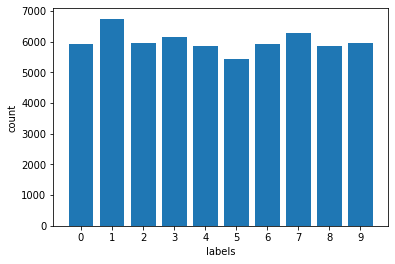

In [7]:
plt.bar(classes, counts)
plt.xticks(classes)
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

## Split train/val: 85/15%

In [8]:
trainval_size = len(trainval_set)
trainval_size

60000

In [9]:
trainval_size = len(trainval_set)
train_size, val_size = int(trainval_size*0.85), int(trainval_size*0.15)

# split
train_set, val_set = torch.utils.data.random_split(trainval_set, [train_size, val_size])

In [10]:
# class distribution in the train set
labels_train = trainval_set.targets[train_set.indices]
train_classes, train_counts = np.unique(labels_train, return_counts=True)

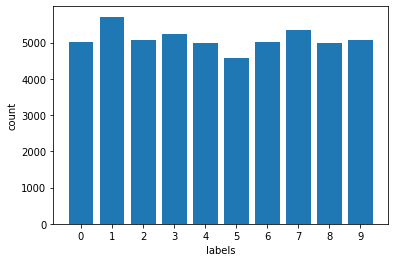

In [11]:
plt.bar(train_classes, train_counts)
plt.xticks(train_classes)
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

Checking that this respected the original class distribution:

In [12]:
trainval_distribution = [count/trainval_size for count in counts]
train_distribution = [count/train_size for count in train_counts]

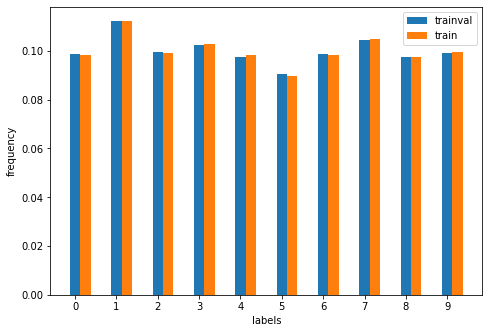

In [13]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes + 0.00, trainval_distribution, width = 0.25)
ax.bar(classes + 0.25, train_distribution,  width = 0.25)
plt.xticks(classes)
plt.xlabel('labels')
plt.ylabel('frequency')
plt.legend(labels=['trainval', 'train'])
plt.show()

## Load

In [14]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [15]:
len(train_loader.sampler)

51000

# Data augmentations

## Individual augmentations

In [16]:
rot = transforms.RandomAffine(
    degrees=20,
    translate=None,
    scale=None,
    shear=None)

trans = transforms.RandomAffine(
    degrees=0,
    translate=(0.10, 0.10),
    scale=None,
    shear=None)

shear = transforms.RandomAffine(
    degrees=0,
    translate=None,
    scale=None,
    shear=[-20, 20, -20, 20],
    fill=0)

In [17]:
def augment(augmentation):
    return transforms.Compose([transforms.Pad(10, fill=0),
                               augmentation,
                               transforms.CenterCrop(28)])

# rotation (random from -20 to 20 degrees)
rotation = transforms.Compose([augment(rot), basic_transform])
trainval_set_rotated = datasets.MNIST('./data', train=True, download=True,
                                        transform=rotation)

# translation (random from -20 to 20 degrees)
translation = transforms.Compose([augment(trans), basic_transform])
trainval_set_translated = datasets.MNIST('./data', train=True, download=True,
                                        transform=translation)

# shear (random from -20 to 20 degrees)
shearing = transforms.Compose([augment(shear), basic_transform])
trainval_set_sheared = datasets.MNIST('./data', train=True, download=True,
                                        transform=shearing)

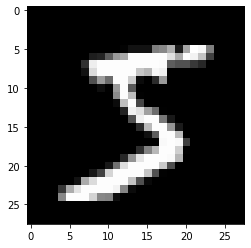

In [18]:
img = trainval_set[0][0]
plt.imshow(img[0], cmap="gray")

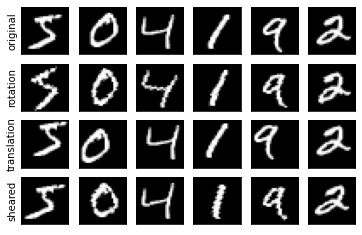

In [19]:
fig, axs = plt.subplots(4, 6)

# original
for i, ax in enumerate(axs[0]):
    ax.imshow(trainval_set[i][0][0], cmap='gray')
    if i==0: ax.set_ylabel('original')

# rotations
for i, ax in enumerate(axs[1]):
    ax.imshow(trainval_set_rotated[i][0][0], cmap='gray')
    if i==0: ax.set_ylabel('rotation')

# translations
for i, ax in enumerate(axs[2]):
    ax.imshow(trainval_set_translated[i][0][0], cmap='gray')
    if i==0: ax.set_ylabel('translation')

# shears
for i, ax in enumerate(axs[3]):
    ax.imshow(trainval_set_sheared[i][0][0], cmap='gray')
    if i==0: ax.set_ylabel('sheared')

for ax in [i for j in range(4) for i in axs[j]]:
    ax.set_xticks([])
    ax.set_yticks([])

#plt.tight_layout()
plt.show()

## Combining all augmentations

In [20]:
rot_trans_shear = transforms.RandomAffine(
    degrees=20,
    translate=(0.10, 0.10),
    scale=None,
    shear=[-20, 20, -20, 20],
    fill=0)

# shear (random from -20 to 20 degrees)
augmentations = transforms.Compose([augment(rot_trans_shear), basic_transform])
trainval_set_augmented = datasets.MNIST('./data', train=True, download=True,
                                        transform=shearing)

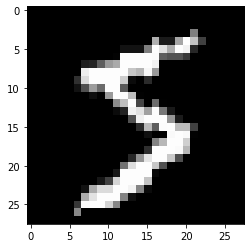

In [21]:
img = trainval_set_augmented[0][0]
plt.imshow(img[0], cmap="gray")